# 함수 및 데이터 분석은 '파이썬 머신러닝 완벽가이드(위키북스)' 책을 옮겨 썼으며, 여러 군집화는 본인이 직접 적용했음을 알리겠습니다.

In [26]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs
import matplotlib.cm as cm
import math
from sklearn.decomposition import PCA

각종 필요한 함수들(군집화를 시각화하거나 점수를 평가하는 함수)

In [27]:
def visualize_silhouette(cluster_lists, X_features):
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    fig.tight_layout()
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\\n' \
                            'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [28]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')
    plt.show()

In [29]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*','d','h']
    isNoise=False
    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',\
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    plt.legend(loc=legend_loc)
    plt.show()

In [30]:
retail_df = pd.read_excel(io = 'Online Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [31]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Qunatity, UnitPrice 가 0보다 큰 데이터와 CustomerID가 null값이 아닌 데이터만 추출.

In [32]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [33]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

영국 데이터외의 데이터 제외

In [34]:
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


데이터 가공 <br>
-> Quantity와 UnitPrice column을 sale_amount로 결합

In [35]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

RFM기반 데이터 가공 <br>
(Recency, Frequency, Monetary value 데이터를 기반한 데이터 가공방법)

In [36]:
aggregations = {'InvoiceDate':'max', 'InvoiceNo':'count','sale_amount':'sum'}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency','InvoiceNo':'Frequency', 'sale_amount':'Monetary'})
cust_df = cust_df.reset_index()
cust_df

,CustomerID,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,1,77183.60
1,12747.0,2011-12-07 14:34:00,103,4196.01
2,12748.0,2011-12-09 12:20:00,4595,33719.73
3,12749.0,2011-12-06 09:56:00,199,4090.88
4,12820.0,2011-12-06 15:12:00,59,942.34
...,...,...,...,...
3915,18280.0,2011-03-07 09:52:00,10,180.60
3916,18281.0,2011-06-12 10:53:00,7,80.82
3917,18282.0,2011-12-02 11:43:00,12,178.05
3918,18283.0,2011-12-06 12:02:00,756,2094.88


Recency는 오늘 날짜 기준으로 가장 최근 주문 일자를 뺀 날짜이다. <br>
오늘을 데이터의 마지막 날짜인 2011년 12월 9일에 하루를 더해 2011년 12월 10일로 가정한다.

In [37]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days + 1)
print(cust_df.shape)
cust_df.head()

(3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,3,103,4196.01
2,12748.0,1,4595,33719.73
3,12749.0,4,199,4090.88
4,12820.0,4,59,942.34


데이터 시각화를 통해 데이터가 왜곡됨을 알 수 있다.

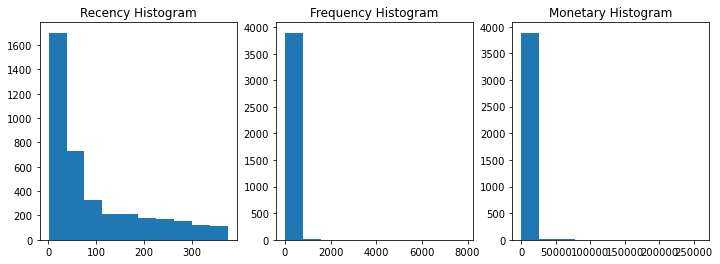

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 4), nrows = 1, ncols = 3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

왜곡된 데이터를 로그변환 후 StandardScaler를 사용 한다.

In [39]:
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

KMeans를 이용한 군집화<br>
KMeans - 군집의 중심점을 임의로 선택해 해당 중심에 가장 가까운 포인트들을 선택하는 군집화 기법, 소속된 데이터의 평균 거리 중심으로 이동한다.

In [40]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels
print(silhouette_score(X_features_scaled, labels))

0.30333901879711767


군집화 cluster를 2~5로 나눠 적용

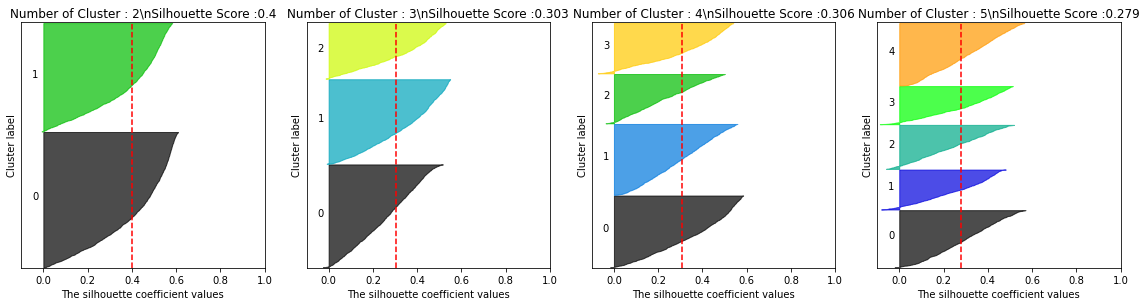

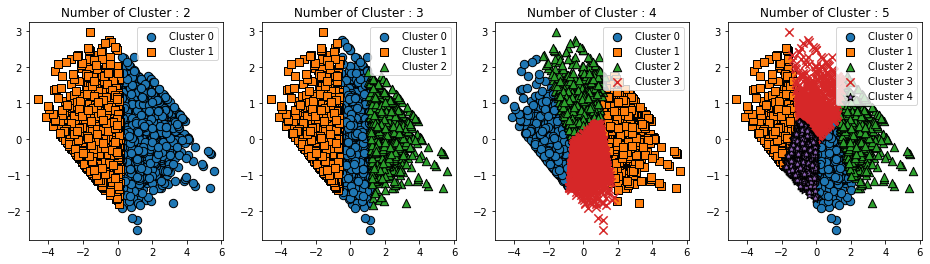

In [41]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

MeanShift를 이용한 군집화<br>
MeanShift - KMeans와 유사하게 중심을 군집의 중심으로 지속적으로 움직이면서 군집화 하지만 KMeans와 다르게 중심을 데이터가 모여있는 밀도가 가장높은 곳으로 이동시킨다.

In [43]:
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
best_bandwidth = estimate_bandwidth(X_features_scaled)
meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(X_features_scaled)
cust_df['meanshift_labels'] = cluster_labels
print("최적대역폭:",meanshift)

최적대역폭: MeanShift(bandwidth=1.5594145725988002)


2차원 시각화를 위해 PCA 적용

In [44]:
pca = PCA(n_components = 2, random_state = 0)
pca_transformed = pca.fit_transform(X_features_scaled)
cust_df['ftr1'] = pca_transformed[:,0]
cust_df['ftr2'] = pca_transformed[:,1]

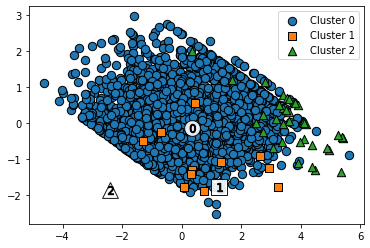

In [56]:
visualize_cluster_plot(meanshift, cust_df, 'meanshift_labels', iscenter = True)

GMM을 이용한 군집화<br>
GMM - 군집화를 적용하고자 하는 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식

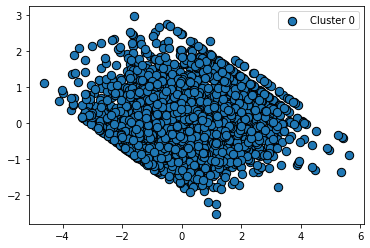

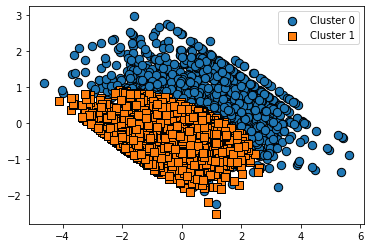

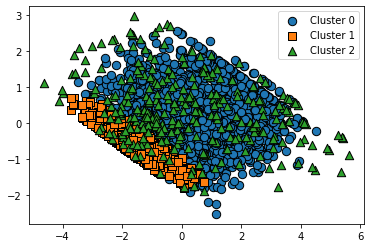

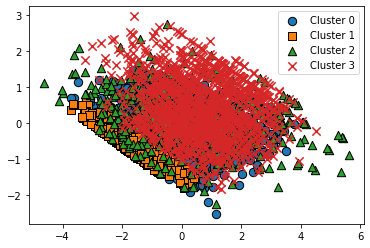

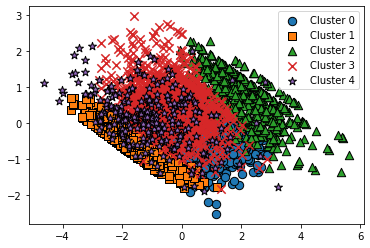

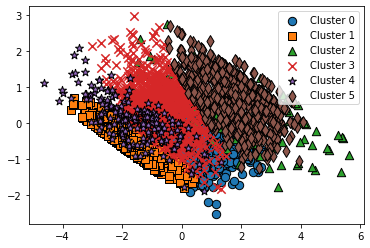

In [48]:
from sklearn.mixture import GaussianMixture
for i in range(1,7):
    gmm = GaussianMixture(n_components = i, random_state = 0)
    gmm_cluster_labels = gmm.fit_predict(X_features_scaled)

    cust_df['gmm_cluster'] = gmm_cluster_labels
    visualize_cluster_plot(gmm, cust_df, 'gmm_cluster', iscenter = False)

DBSCAN을 이용한 군집화<br>
DBSCAN - 특정 공간 내에 데이터 밀도차이를 기반으로 군집화를 수행한다.<br>
그렇기 때문에 아래와 같은 데이터에서 cluster는 주로 1개가 나온다.

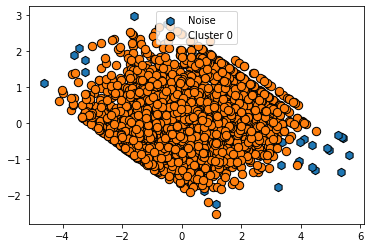

In [55]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.6, min_samples = 6, metric = 'euclidean')
dbscan_labels = dbscan.fit_predict(X_features_scaled)
cust_df['dbscan_labels'] = dbscan_labels

visualize_cluster_plot(dbscan, cust_df, 'dbscan_labels', iscenter = False)